In [1]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [40]:
import math
import random
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torch import nn, optim, Tensor
from torch.autograd import Variable
from torch.utils import model_zoo
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import torchvision

from torchvision import datasets, transforms
from torchvision.models.resnet import BasicBlock

from functools import partial
from typing import Any, Callable, List, Optional, Tuple, Sequence
import warnings


In [4]:
from torchvision.transforms._presets import ImageClassification
from torchvision.utils import _log_api_usage_once
from torchvision.ops.misc import Conv2dNormActivation
from torchvision.models._api import register_model, Weights, WeightsEnum
from torchvision.models._meta import _IMAGENET_CATEGORIES
from torchvision.models._utils import _make_divisible, _ovewrite_named_param, handle_legacy_interface

In [36]:
import matplotlib.pyplot as plt

def plot_performance(train_acc, test_acc, train_loss, test_loss, epochs):

    epochs_range = range(1, epochs + 1)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Adjust the size as needed
    fig.suptitle('Training and Testing Performance')

    # train acc
    axes[0].plot(epochs_range, train_acc, label='Training Accuracy', marker='o')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Training Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # test acc
    axes[1].plot(epochs_range, test_acc, label='Testing Accuracy', color='orange', marker='o')
    axes[1].set_xlabel('Epochs')
    axes[1].set_title('Testing Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    # train loss
    axes[2].plot(epochs_range, train_loss, label='Training Loss', marker='o', linestyle='--')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Loss')
    axes[2].set_title('Training Loss')
    axes[2].legend()
    axes[2].grid(True)

    # test loss
    axes[3].plot(epochs_range, test_loss, label='Testing Loss', color='orange', marker='o', linestyle='--')
    axes[3].set_xlabel('Epochs')
    axes[3].set_title('Testing Loss')
    axes[3].legend()
    axes[3].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [5]:
class InvertedResidual(nn.Module):
    def __init__(
        self, inp: int, oup: int, stride: int, expand_ratio: int, norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super().__init__()
        self.stride = stride
        if stride not in [1, 2]:
            raise ValueError(f"stride should be 1 or 2 instead of {stride}")

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers: List[nn.Module] = []
        if expand_ratio != 1:
            # pw
            layers.append(
                Conv2dNormActivation(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer, activation_layer=nn.ReLU6)
            )
        layers.extend(
            [
                # dw
                Conv2dNormActivation(
                    hidden_dim,
                    hidden_dim,
                    stride=stride,
                    groups=hidden_dim,
                    norm_layer=norm_layer,
                    activation_layer=nn.ReLU6,
                ),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                norm_layer(oup),
            ]
        )
        self.conv = nn.Sequential(*layers)
        self.out_channels = oup
        self._is_cn = stride > 1

    def forward(self, x: Tensor) -> Tensor:
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(
        self,
        classes: int = 1000,
        width_mult: float = 1.0,
        inverted_residual_setting: Optional[List[List[int]]] = None,
        round_nearest: int = 8,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        dropout: float = 0.2,
    ) -> None:
        """
        MobileNet V2 main class

        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
            block: Module specifying inverted residual building block for mobilenet
            norm_layer: Module specifying the normalization layer to use
            dropout (float): The droupout probability

        """
        super().__init__()
        _log_api_usage_once(self)

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError(
                f"inverted_residual_setting should be non-empty or a 4-element list, got {inverted_residual_setting}"
            )

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features: List[nn.Module] = [
            Conv2dNormActivation(3, input_channel, stride=2, norm_layer=norm_layer, activation_layer=nn.ReLU6)
        ]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
        # building last several layers
        features.append(
            Conv2dNormActivation(
                input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer, activation_layer=nn.ReLU6
            )
        )
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(self.last_channel, classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> torch.Tensor:
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def forward(self, x: Tensor, gt=None, flag=None, epoch=None) -> torch.Tensor:
        return self._forward_impl(x)

def mobilenet_v2(pretrained = True, **kwargs: Any):
    """MobileNetV2 architecture from the `MobileNetV2: Inverted Residuals and Linear
    Bottlenecks <https://arxiv.org/abs/1801.04381>`_ paper.

    Args:
        weights (:class:`~torchvision.models.MobileNet_V2_Weights`, optional): The
            pretrained weights to use. See
            :class:`~torchvision.models.MobileNet_V2_Weights` below for
            more details, and possible values. By default, no pre-trained
            weights are used.
        progress (bool, optional): If True, displays a progress bar of the
            download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.models.mobilenetv2.MobileNetV2``
            base class. Please refer to the `source code
            <https://github.com/pytorch/vision/blob/main/torchvision/models/mobilenetv2.py>`_
            for more details about this class.

    .. autoclass:: torchvision.models.MobileNet_V2_Weights
        :members:
    """
    model = MobileNetV2(**kwargs)

    if pretrained:
        model.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/mobilenet_v2-b0353104.pth'))

    return model



In [12]:
# from functools import partial
# from typing import Any, cast, Dict, List, Optional, Union

# import torch
# import torch.nn as nn


# class VGG(nn.Module):
#     def __init__(
#         self, features: nn.Module, classes: int = 1000, init_weights: bool = True, dropout: float = 0.5
#     ) -> None:
#         super().__init__()
#         self.features = features
#         self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
#         self.classifier = nn.Sequential(
#             nn.Linear(512 * 7 * 7, 4096),
#             nn.ReLU(True),
#             nn.Dropout(p=dropout),
#             nn.Linear(4096, 4096),
#             nn.ReLU(True),
#             nn.Dropout(p=dropout),
#             nn.Linear(4096, classes),
#         )
#         if init_weights:
#             for m in self.modules():
#                 if isinstance(m, nn.Conv2d):
#                     nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
#                     if m.bias is not None:
#                         nn.init.constant_(m.bias, 0)
#                 elif isinstance(m, nn.BatchNorm2d):
#                     nn.init.constant_(m.weight, 1)
#                     nn.init.constant_(m.bias, 0)
#                 elif isinstance(m, nn.Linear):
#                     nn.init.normal_(m.weight, 0, 0.01)
#                     nn.init.constant_(m.bias, 0)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x


# def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
#     layers: List[nn.Module] = []
#     in_channels = 3
#     for v in cfg:
#         if v == "M":
#             layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
#         else:
#             v = cast(int, v)
#             conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
#             if batch_norm:
#                 layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
#             else:
#                 layers += [conv2d, nn.ReLU(inplace=True)]
#             in_channels = v
#     return nn.Sequential(*layers)


# cfgs: Dict[str, List[Union[str, int]]] = {
#     "A": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
#     "B": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
#     "D": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
#     "E": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"],
# }


# def vgg16(cfg: str, pretrained=True, **kwargs):
#     # if weights is not None:
#     #     kwargs["init_weights"] = Fals
#     #     if weights.meta["categories"] is not None:
#     #         _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))
#     model = VGG(make_layers(cfgs[cfg], batch_norm=False), **kwargs)
#     if pretrained:
#         model.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/vgg16-397923af.pth'), strict=False)

#     return model

In [ ]:
cfgs

In [ ]:

class AlexNet(nn.Module):
    def __init__(self, classes=100, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, classes),
        )

    def forward(self, x, gt=None, flag=None, epoch=None) -> torch.Tensor:
        x = self.features(x)

        if flag:
            interval = 10
            if epoch % interval == 0:
                self.pecent = 3.0 / 10 + (epoch / interval) * 2.0 / 10

            self.eval()
            x_new = x.clone().detach()
            x_new = Variable(x_new.data, requires_grad=True)
            x_new_view = self.avgpool(x_new)
            x_new_view = x_new_view.view(x_new_view.size(0), -1)
            output = self.classifier(x_new_view)
            class_num = output.shape[1]
            index = gt
            num_rois = x_new.shape[0]
            num_channel = x_new.shape[1]
            H = x_new.shape[2]
            HW = x_new.shape[2] * x_new.shape[3]
            one_hot = torch.zeros((1), dtype=torch.float32).cuda()
            one_hot = Variable(one_hot, requires_grad=False)
            sp_i = torch.ones([2, num_rois]).long()
            sp_i[0, :] = torch.arange(num_rois)
            sp_i[1, :] = index
            sp_v = torch.ones([num_rois])
            one_hot_sparse = torch.sparse.FloatTensor(sp_i, sp_v, torch.Size([num_rois, class_num])).to_dense().cuda()
            one_hot_sparse = Variable(one_hot_sparse, requires_grad=False)
            one_hot = torch.sum(output * one_hot_sparse)
            self.zero_grad()
            one_hot.backward()
            grads_val = x_new.grad.clone().detach()
            grad_channel_mean = torch.mean(grads_val.view(num_rois, num_channel, -1), dim=2)
            channel_mean = grad_channel_mean
            grad_channel_mean = grad_channel_mean.view(num_rois, num_channel, 1, 1)
            spatial_mean = torch.sum(x_new * grad_channel_mean, 1)
            spatial_mean = spatial_mean.view(num_rois, HW)
            self.zero_grad()

            choose_one = random.randint(0, 9)
            if choose_one <= 4:
                # ---------------------------- spatial -----------------------
                mask_all = self.spatial_RCS(num_rois, H, HW, spatial_mean)
            else:
                # -------------------------- channel ----------------------------
                mask_all = self.channel_RCS(num_rois, num_channel, channel_mean)

            # ----------------------------------- batch ----------------------------------------
            cls_prob_before = F.softmax(output, dim=1)
            x_new_view_after = x_new * mask_all
            x_new_view_after = self.avgpool(x_new_view_after)
            x_new_view_after = x_new_view_after.view(x_new_view_after.size(0), -1)
            x_new_view_after = self.classifier(x_new_view_after)
            cls_prob_after = F.softmax(x_new_view_after, dim=1)

            sp_i = torch.ones([2, num_rois]).long()
            sp_i[0, :] = torch.arange(num_rois)
            sp_i[1, :] = index
            sp_v = torch.ones([num_rois])
            one_hot_sparse = torch.sparse.FloatTensor(sp_i, sp_v, torch.Size([num_rois, class_num])).to_dense().cuda()
            before_vector = torch.sum(one_hot_sparse * cls_prob_before, dim=1)
            after_vector = torch.sum(one_hot_sparse * cls_prob_after, dim=1)
            change_vector = before_vector - after_vector - 0.0001
            change_vector = torch.where(change_vector > 0, change_vector, torch.zeros(change_vector.shape).cuda())
            th_fg_value = torch.sort(change_vector, dim=0, descending=True)[0][int(round(float(num_rois) * self.pecent))]
            drop_index_fg = change_vector.gt(th_fg_value).long()
            ignore_index_fg = 1 - drop_index_fg
            not_01_ignore_index_fg = ignore_index_fg.nonzero()[:, 0]
            mask_all[not_01_ignore_index_fg.long(), :] = 1

            self.train()
            mask_all = Variable(mask_all, requires_grad=True)
            x = x * mask_all

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def channel_RCS(self, num_rois, num_channel, channel_mean):
        vector_thresh_percent = math.ceil(num_channel * 1 / 3.2)
        vector_thresh_value = torch.sort(channel_mean, dim=1, descending=True)[0][:, vector_thresh_percent]
        vector_thresh_value = vector_thresh_value.view(num_rois, 1).expand(num_rois, num_channel)
        vector = torch.where(channel_mean > vector_thresh_value,
                                     torch.zeros(channel_mean.shape).cuda(),
                                     torch.ones(channel_mean.shape).cuda())
        mask_all = vector.view(num_rois, num_channel, 1, 1)
        return mask_all

    def spatial_RCS(self, num_rois, H, HW, spatial_mean):
        spatial_drop_num = math.ceil(HW * 1 / 3.0)
        th18_mask_value = torch.sort(spatial_mean, dim=1, descending=True)[0][:, spatial_drop_num]
        th18_mask_value = th18_mask_value.view(num_rois, 1).expand(num_rois, 36)
        mask_all_cuda = torch.where(spatial_mean > th18_mask_value, torch.zeros(spatial_mean.shape).cuda(),
                                            torch.ones(spatial_mean.shape).cuda())
        mask_all = mask_all_cuda.reshape(num_rois, H, H).view(num_rois, 1, H, H)
        return mask_all

def alex(pretrained=True, **kwargs):
    """
    Constructs a custom alexnet model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        # Load the original AlexNet
        alexnet_original = models.alexnet(pretrained=True)

        # Copy weights for the common layers
        # Features
        for layer, param in model.features.named_parameters():
            param.data = alexnet_original.features.state_dict()[layer].data

        # Classifier (except for the final layer)
        for layer, param in model.classifier.named_parameters():
            if '6' not in layer:  # Skip the final layer
                param.data = alexnet_original.classifier.state_dict()[layer].data

    return model

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, jigsaw_classes=1000, classes=100):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        # self.jigsaw_classifier = nn.Linear(512 * block.expansion, jigsaw_classes)
        self.class_classifier = nn.Linear(512 * block.expansion, classes)
        #self.domain_classifier = nn.Linear(512 * block.expansion, domains)
        self.pecent = 1/3

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def is_patch_based(self):
        return False

    def forward(self, x, gt=None, flag=None, epoch=None):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if flag:
            interval = 10
            if epoch % interval == 0:
                self.pecent = 3.0 / 10 + (epoch / interval) * 2.0 / 10

            self.eval()
            x_new = x.clone().detach() # 128，512，7，7
            x_new = Variable(x_new.data, requires_grad=True)
            x_new_view = self.avgpool(x_new) # 128 512 1 1
            x_new_view = x_new_view.view(x_new_view.size(0), -1)
            output = self.class_classifier(x_new_view)
            class_num = output.shape[1]
            index = gt
            num_rois = x_new.shape[0]
            num_channel = x_new.shape[1]
            H = x_new.shape[2]
            HW = x_new.shape[2] * x_new.shape[3]
            one_hot = torch.zeros((1), dtype=torch.float32).cuda() #
            one_hot = Variable(one_hot, requires_grad=False)
            sp_i = torch.ones([2, num_rois]).long()
            sp_i[0, :] = torch.arange(num_rois)
            sp_i[1, :] = index # location
            sp_v = torch.ones([num_rois]) # value
            one_hot_sparse = torch.sparse.FloatTensor(sp_i, sp_v, torch.Size([num_rois, class_num])).to_dense().cuda()
            one_hot_sparse = Variable(one_hot_sparse, requires_grad=False)
            one_hot = torch.sum(output * one_hot_sparse) # output-logits; class score: good bad
            self.zero_grad()
            one_hot.backward()
            grads_val = x_new.grad.clone().detach() # d(class score)/dx_new [128,512,7,7]
            grad_channel_mean = torch.mean(grads_val.view(num_rois, num_channel, -1), dim=2) # 128,512,49
            channel_mean = grad_channel_mean
            grad_channel_mean = grad_channel_mean.view(num_rois, num_channel, 1, 1)# grad_channel_mean [128 512 1 1] -->copy49 [128 512 7 7]
            spatial_mean = torch.sum(x_new * grad_channel_mean, 1) # x_new [128,512,7,7] # grad_channel_mean [128 512 1 1]
            spatial_mean = spatial_mean.view(num_rois, HW)
            self.zero_grad()

            choose_one = random.randint(0, 9)
            if choose_one <= 4:
                # ---------------------------- spatial -----------------------
                mask_all = self.spatial_RCS(num_rois, H, HW, spatial_mean)
            else:
                # -------------------------- channel ----------------------------
                mask_all = self.channel_RCS(num_rois, num_channel, channel_mean)

            # ----------------------------------- batch ----------------------------------------
            cls_prob_before = F.softmax(output, dim=1)
            x_new_view_after = x_new * mask_all
            x_new_view_after = self.avgpool(x_new_view_after)
            x_new_view_after = x_new_view_after.view(x_new_view_after.size(0), -1)
            x_new_view_after = self.class_classifier(x_new_view_after)
            cls_prob_after = F.softmax(x_new_view_after, dim=1)

            sp_i = torch.ones([2, num_rois]).long()
            sp_i[0, :] = torch.arange(num_rois)
            sp_i[1, :] = index
            sp_v = torch.ones([num_rois])
            one_hot_sparse = torch.sparse.FloatTensor(sp_i, sp_v, torch.Size([num_rois, class_num])).to_dense().cuda()
            before_vector = torch.sum(one_hot_sparse * cls_prob_before, dim=1)
            after_vector = torch.sum(one_hot_sparse * cls_prob_after, dim=1)
            change_vector = before_vector - after_vector - 0.0001
            change_vector = torch.where(change_vector > 0, change_vector, torch.zeros(change_vector.shape).cuda())
            th_fg_value = torch.sort(change_vector, dim=0, descending=True)[0][int(round(float(num_rois) * self.pecent))]
            drop_index_fg = change_vector.gt(th_fg_value).long()
            ignore_index_fg = 1 - drop_index_fg
            not_01_ignore_index_fg = ignore_index_fg.nonzero()[:, 0]
            mask_all[not_01_ignore_index_fg.long(), :] = 1

            self.train()
            mask_all = Variable(mask_all, requires_grad=True)
            x = x * mask_all

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.class_classifier(x)

    def channel_RCS(self, num_rois, num_channel, channel_mean):
        vector_thresh_percent = math.ceil(num_channel * 1 / 3.2)
        vector_thresh_value = torch.sort(channel_mean, dim=1, descending=True)[0][:, vector_thresh_percent]
        vector_thresh_value = vector_thresh_value.view(num_rois, 1).expand(num_rois, num_channel)
        vector = torch.where(channel_mean > vector_thresh_value,
                                     torch.zeros(channel_mean.shape).cuda(),
                                     torch.ones(channel_mean.shape).cuda())
        mask_all = vector.view(num_rois, num_channel, 1, 1)
        return mask_all

    def spatial_RCS(self, num_rois, H, HW, spatial_mean):
        spatial_drop_num = math.ceil(HW * 1 / 3.0)
        th18_mask_value = torch.sort(spatial_mean, dim=1, descending=True)[0][:, spatial_drop_num]
        th18_mask_value = th18_mask_value.view(num_rois, 1).expand(num_rois, 49)
        mask_all_cuda = torch.where(spatial_mean > th18_mask_value, torch.zeros(spatial_mean.shape).cuda(),
                                            torch.ones(spatial_mean.shape).cuda())
        mask_all = mask_all_cuda.reshape(num_rois, H, H).view(num_rois, 1, H, H)
        return mask_all

def resnet18(pretrained=True, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/resnet18-5c106cde.pth'), strict=False)
    return model


# With domain adaption Office home dataset

In [6]:
def get_model(model_name, pretrained=True, **kwargs):
    if model_name == 'resnet':
        model_class = resnet18
        return model_class(pretrained=pretrained, **kwargs)
    elif model_name == 'alexnet':
        model_class = alex
        return model_class(pretrained=pretrained, **kwargs)
    elif model_name == 'mobilenet_v2':
        model_class = mobilenet_v2

        numClasses = kwargs['classes']
        kwargs['classes'] = 1000
        model = model_class(pretrained=pretrained, **kwargs)
        num_input_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_input_features, numClasses)

        for param in model.parameters():
            param.requires_grad = False

        for param in model.classifier[1].parameters():
            param.requires_grad = True

        return model
    else:
        raise ValueError(f"Unsupported model name: {model_name}")


#Accelerate the training
torch.backends.cudnn.benchmark = True
torch.manual_seed(0)
torch.cuda.manual_seed(0)


print("Target domain: {}".format('Real world'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
n_classes = 65
model = get_model('mobilenet_v2', pretrained=True, classes=n_classes)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/starsdliu/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Target domain: Real world


100%|██████████████████████████████████████| 13.6M/13.6M [00:00<00:00, 46.6MB/s]


In [7]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [10]:
# Data loaders
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
    transforms.RandomGrayscale(0.1),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x.float()),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224,224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x.float()),
])

directory = '../../OfficeHomeDataset_10072016'
concatenated_datasets = []
total_size = 0

for name in ["Art","Clipart","Product"]:
    dataset = datasets.ImageFolder(
        f'{directory}/{name}',
        transform=train_transform
    )
    total_size += len(dataset)
    concatenated_datasets.append(dataset)

combined_dataset = ConcatDataset(concatenated_datasets)
indices = list(range(total_size))
random.shuffle(indices)
random_subset = Subset(combined_dataset, indices)
source_loader = DataLoader(random_subset, batch_size=64, shuffle=True)

target_dataset = datasets.ImageFolder(
    f'{directory}/Real World',
    transform=val_transform)
target_loader = torch.utils.data.DataLoader(target_dataset , batch_size=64, shuffle=True)


In [14]:
# Optimizer and scheduler

params = model.parameters()

optimizer = optim.SGD(params, weight_decay=.0005, momentum=.9, nesterov=False, lr=0.01)
#optimizer = optim.Adam(params, lr=lr)
step_size = int(20 * .8)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size)

print("Step size: %d" % step_size)

# Training and testing loop
results = {"training_loss": [], "training_acc": [], "test_loss": [], "test_acc": []}
criterion = nn.CrossEntropyLoss()

writer = SummaryWriter('test')
global_step = 0

# keep track of loss
training_losses = []
training_accs = []
test_losses = []
test_accs = []

# Early Stopping
epochs_early_stopping = 20
epochs_min_change = 0.0001
best_test_loss = float('inf')

for now_epoch in range(20):

    lr = scheduler.get_lr()[0]


    # Training
    model.train()
    epoch_train_loss = 0.0
    epoch_train_accs = 0.0
    train_total = len(source_loader)
    for it, batch in enumerate(source_loader):

        data, labels = batch

        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()

        data_fliped = torch.flip(data, (3,)).detach().clone()
        data = torch.cat((data, data_fliped))
        labels_labels_flip = torch.cat((labels, labels))

        class_logit = model(data, labels_labels_flip, True, now_epoch)
        # class_logit = model(data)
        class_loss = criterion(class_logit, labels_labels_flip)
        _, cls_pred = class_logit.max(dim=1)
        loss = class_loss

        loss.backward()
        optimizer.step()

        class_loss_train = class_loss.item()
        accuracy = torch.sum(cls_pred == labels_labels_flip.data).item() / data.shape[0]
#         print(accuracy)
        writer.add_scalar('Loss/Train', class_loss_train, global_step)
        writer.add_scalar('Accuracy/Train', accuracy, global_step)
        global_step += 1

        epoch_train_loss += class_loss_train
        epoch_train_accs += accuracy

        del loss, class_loss, class_logit

    epoch_train_loss = epoch_train_loss / train_total
    epoch_train_accs = epoch_train_accs / train_total

    if(now_epoch % 1 == 0):
        print(f"Training epoch {now_epoch}/{20} - "
              f"loss: {epoch_train_loss} - acc: {epoch_train_accs * 100 : 2f}%")

    training_losses.append(epoch_train_loss)
    training_accs.append(epoch_train_accs)

    scheduler.step()
    writer.add_scalar('Learning Rate', lr, now_epoch)
    # Testing
    model.eval()
    epoch_test_loss = 0.0
    epoch_test_accs = 0.0
    with torch.no_grad():
        class_correct = 0
        total = len(target_loader)
        for it, batch in enumerate(target_loader):
            data, labels = batch

            data, labels = data.to(device), labels.to(device)

            # class_logit = model(data)
            class_logit = model(data, labels, False)
            test_loss = criterion(class_logit, labels)
            _, cls_pred = class_logit.max(dim=1)

            accuracy = torch.sum(cls_pred == labels.data) / data.shape[0]
#             print("testing" + str(accuracy))
            epoch_test_loss += test_loss.item()
            epoch_test_accs += accuracy.item()

        epoch_test_loss = epoch_test_loss / total
        epoch_test_accs = epoch_test_accs / total

        writer.add_scalar('Test/Accuracy', epoch_test_accs, now_epoch)
        if(now_epoch % 1 == 0):
            print(f"Testing - acc: {epoch_test_accs * 100 : 2f}%")

    test_losses.append(epoch_test_loss)
    test_accs.append(epoch_test_accs)

    if epoch_test_loss < (best_test_loss - epochs_min_change):
        print("Test Loss Improved from {:.4f} to {:.4f}".format(best_test_loss, epoch_test_loss))
        best_test_loss = epoch_test_loss
        epochs_early_stopping = 20
        torch.save(model.state_dict(), './savedModels/mobilenetv2_model_best.pth')
        print("Model saved as ./savedModels/vgg16_model_best.pth")
    else:
        epochs_early_stopping -= 1
        print(f"No improvement in test loss for {20 - epochs_early_stopping} consecutive epochs.")

    # Check if Early Stopping is needed
    if epochs_early_stopping == 0:
        print(f"Early stopping after {now_epoch + 1} epochs!")
        break



results['training_loss'] = training_losses
results['training_acc'] = training_accs
results['test_loss'] = test_losses
results['test_accuracy'] = test_accs

Step size: 16
Training epoch 0/20 - loss: 1.477990149097009 - acc:  62.109089%
Testing - acc:  67.699280%
Test Loss Improved from inf to 1.2021
Model saved as ./savedModels/vgg16_model_best.pth
Training epoch 1/20 - loss: 1.289055803621357 - acc:  65.919973%
Testing - acc:  69.524452%
Test Loss Improved from 1.2021 to 1.1220
Model saved as ./savedModels/vgg16_model_best.pth
Training epoch 2/20 - loss: 1.1940693005242131 - acc:  68.172224%
Testing - acc:  68.768120%
No improvement in test loss for 1 consecutive epochs.
Training epoch 3/20 - loss: 1.1407989280467683 - acc:  69.200049%
Testing - acc:  68.215576%
No improvement in test loss for 2 consecutive epochs.
Training epoch 4/20 - loss: 1.0875520696016876 - acc:  70.501798%
Testing - acc:  69.316124%
Test Loss Improved from 1.1220 to 1.1158
Model saved as ./savedModels/vgg16_model_best.pth
Training epoch 5/20 - loss: 1.0546822978014296 - acc:  71.731379%
Testing - acc:  68.713768%
No improvement in test loss for 1 consecutive epochs

In [35]:
import json
file_path = './Saved Results/trainValidationLossAccuracy.json'
with open(file_path, 'w') as file:
    json.dump(results, file)

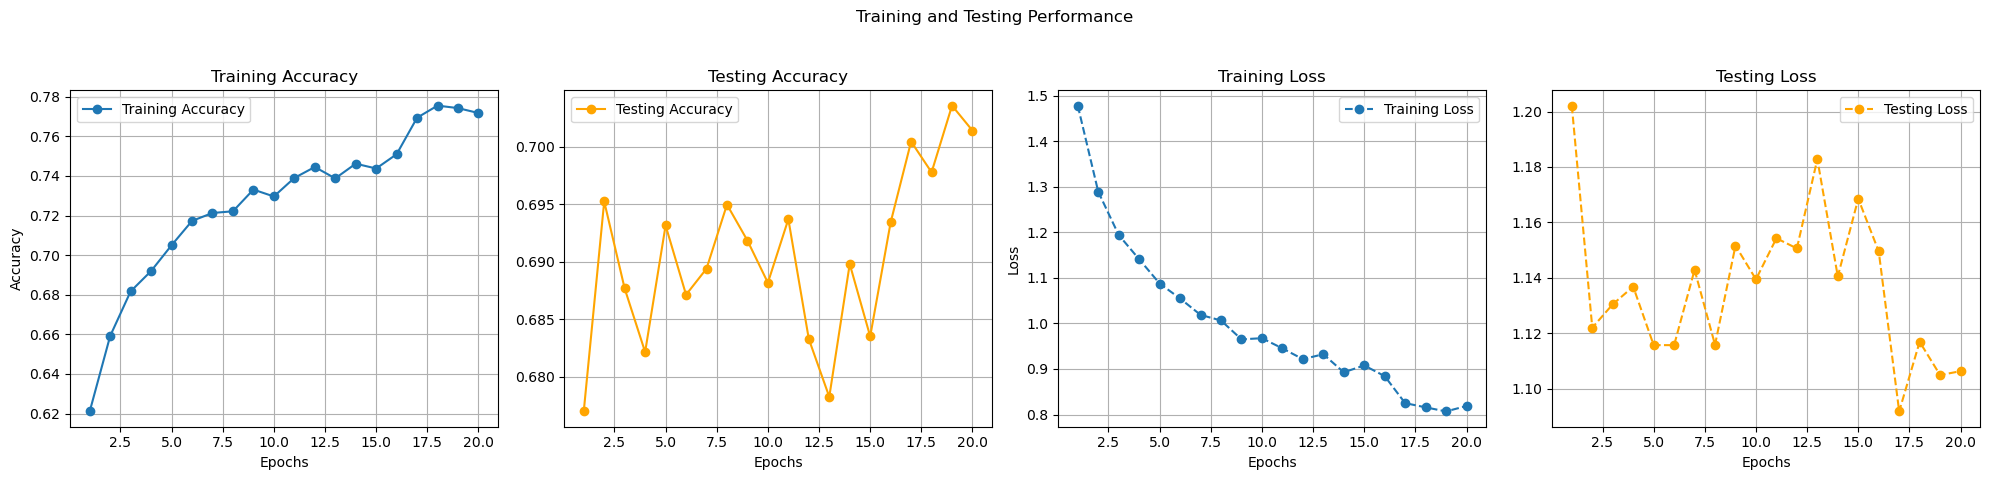

In [37]:
plot_performance(training_accs, test_accs, training_losses, test_losses, 20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


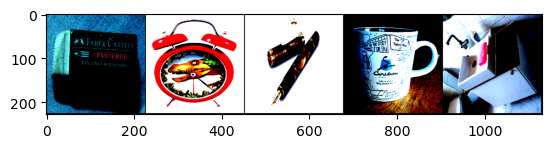

In [41]:

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize if your images were normalized
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Create an iterator from the DataLoader
dataiter = iter(target_loader)

# Get a batch of training images
examine_images, examine_labels = next(dataiter)

# Select only the first 5 images and labels
examine_images = examine_images[:5]
examine_labels = examine_labels[:5]

# Show images
imshow(torchvision.utils.make_grid(examine_images))

In [45]:
best_mnet = mobilenet_v2() 

state_dict = torch.load('./savedModels/mobilenetv2_model_best.pth')

num_input_features = best_mnet.classifier[1].in_features
best_mnet.classifier[1] = nn.Linear(num_input_features, 65)
best_mnet.load_state_dict(state_dict)

gpu_boole = torch.backends.mps.is_available()

# device = torch.device("cuda:0" if gpu_boole else "cpu")
# device = torch.device("mps" if gpu_boole else "cpu")
best_mnet = best_mnet.to(device)
print(best_mnet)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [47]:
examine_images
examine_labels

testdata, testlabels = examine_images.to(device), examine_labels.to(device)

# class_logit = model(data)
testclass_logit = best_mnet(testdata, testlabels, False)
_, cls_pred = testclass_logit.max(dim=1)
cls_pred

tensor([47, 31, 42, 37, 53])